# RetinaNet Demo

## Part 1: Image Part

### import packages

In [ ]:
# import packages
from google.colab import drive
from google.colab.patches import cv2_imshow
import torchvision.transforms as transforms
import cv2
import numpy as np
import torch
import os
import torchvision
import torch
import argparse
from PIL import Image
import time
from IPython.display import HTML
from base64 import b64encode

### Mount Drive, Find path of images and videos

In [ ]:
# mount gdrive
drive.mount('/content/drive')

# get image path
path_root = os.getcwd()
path_input = path_root + "/drive/My Drive/RetinaNet/input/"
path_output = path_root + "/drive/My Drive/RetinaNet/output/"
name_images = os.listdir(path_input)
path_images = path_input + 'compressed_1.jpg'

# compress image for better run tiem
# img = Image.open(path_images)
# img = img.resize((int(img.size[0]*0.4),int(img.size[1]*0.4)),Image.ANTIALIAS)
# img.save(path_input + 'compressed_3.jpg', optimize=True, quality = 60)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Show sample image

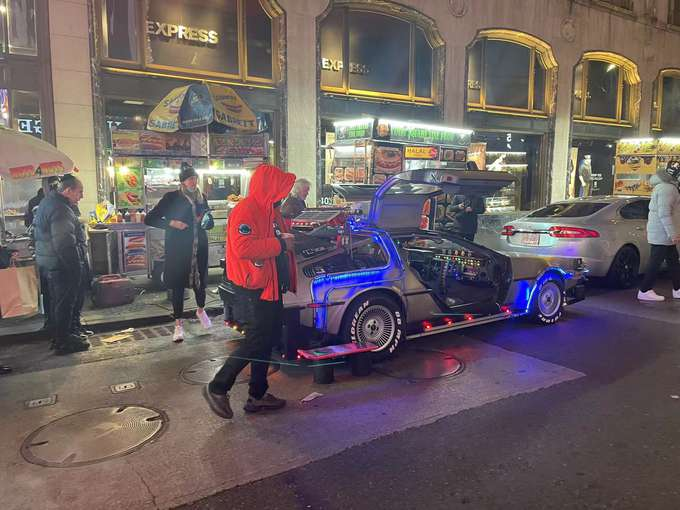

In [ ]:
img = cv2.imread(path_images)
cv2_imshow(img)

### Define functions for perdiction and drawing bounding boxes

In [ ]:
# pre-define coco classes
coco_names = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# this will help us create a different color for each class
COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))

# define the torchvision image transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])

def predict(image, model, device, detection_threshold):
    # transform the image to tensor
    image = transform(image).to(device)
    image = image.unsqueeze(0) # add a batch dimension
    with torch.no_grad():
        outputs = model(image) # get the predictions on the image
    # get all the scores
    scores = list(outputs[0]['scores'].detach().cpu().numpy())
    # index of those scores which are above a certain threshold
    thresholded_preds_inidices = [scores.index(i) for i in scores if i > detection_threshold]
    # get all the predicted bounding boxes
    bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    # get boxes above the threshold score
    boxes = bboxes[np.array(scores) >= detection_threshold].astype(np.int32)
    # get all the predicited class names
    labels = outputs[0]['labels'].cpu().numpy()
    pred_classes = [coco_names[labels[i]] for i in thresholded_preds_inidices]
    return boxes, pred_classes

def draw_boxes(boxes, classes, image):
    for i, box in enumerate(boxes):
        color = COLORS[coco_names.index(classes[i])]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        cv2.putText(image, classes[i], (int(box[0]), int(box[1]-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, 
                    lineType=cv2.LINE_AA)
    return image

### Load Model, Do Prediction and Show Result

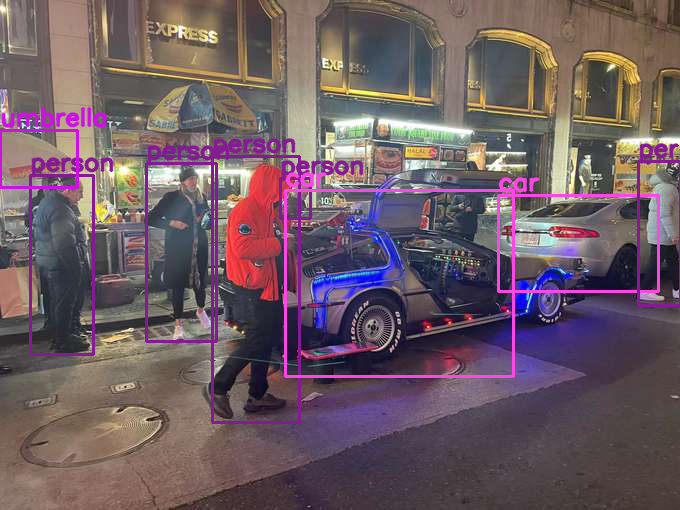

--- 0.6157135963439941 seconds ---


In [ ]:
args = {'min_size': 800, 'input': path_images, 'threshold': 0.6}
# download or load the model from disk
model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True, 
                                                            min_size=args['min_size'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# load the model onto the computation device
model.eval().to(device)

# record prediction time 
start_time = time.time()

image = Image.open(args['input']).convert('RGB')
# a NumPy copy for OpenCV functions
image_array = np.array(image)
# convert to OpenCV BGR color format
image_array = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)
image_copy = image_array.copy()
# get the bounding boxes and class labels
boxes, classes = predict(image, model, device, args['threshold'])
end_time = time.time()
# get the final image
draw_boxes(boxes, classes, image_array)
cv2_imshow(image_array)
print("--- %s seconds ---" % (time.time() - start_time))

## Part 2: Video Part

### Show sample video

In [ ]:
video_path = path_input + 'video1.mp4'
mp4 = open(video_path, "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""
<video width=1200 controls>
      <source src="{data_url}" type="video/mp4">
</video>
""")

### Do Prediction and Write output video stream

In [ ]:
args = {'min_size': 800, 'input': video_path, 'threshold': 0.6}
cap = cv2.VideoCapture(args['input'])
if (cap.isOpened() == False):
    print('Error while trying to read video. Please check path again')
# get the frame width and height
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
save_name = f"{args['input'].split('/')[-1].split('.')[0]}_{args['min_size']}_t{int(args['threshold']*100)}"
# define codec and create VideoWriter object 
video_result_path = path_output + save_name + ".mp4"
out = cv2.VideoWriter(video_result_path, 
                      cv2.VideoWriter_fourcc(*'mp4v'), 20, 
                      (frame_width, frame_height))
frame_count = 0 # to count total frames
total_fps = 0 # to get the final frames per second

# read until end of video
while(cap.isOpened()):
    # capture each frame of the video
    ret, frame = cap.read()
    if ret == True:
        # convert the frame into PIL Image format
        pil_image = Image.fromarray(frame).convert('RGB')
        # get the start time
        start_time = time.time()
        
        # get predictions for the current frame
        boxes, classes = predict(pil_image, model, device, args['threshold'])
        # draw boxes and show current frame on screen
        result = draw_boxes(boxes, classes, frame)
        # get the end time
        end_time = time.time()
        # get the fps
        fps = 1 / (end_time - start_time)
        # add fps to total fps
        total_fps += fps
        # increment frame count
        frame_count += 1
        # press `q` to exit
        wait_time = max(1, int(fps/4))
        out.write(result)
        if cv2.waitKey(wait_time) & 0xFF == ord('q'):
            break
    else:
        break

# calculate and print the average FPS
cap.release()
out.release()
avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")

Average FPS: 2.329


### Show result video

In [ ]:
video_path = path_output + 'output.mp4'
mp4 = open(video_path, "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""
<video width=1200 controls>
      <source src="{data_url}" type="video/mp4">
</video>
""")

@author: [Jiawei Lu](https://jiawei-lu.com)